# PHASE_5_CAPSTONE_PROJECT

##  TRANSFER LEARNING - RESNET50

### Data source

The data source consists of over 44 thousand fashion images from Kaggle.

Source link: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

### ResNet50 introduction

ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. CNNs are commonly used to power computer vision applications.

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

The original ResNet architecture was ResNet-34, which comprised 34 weighted layers. It provided a novel way to add more convolutional layers to a CNN, without running into the vanishing gradient problem, using the concept of shortcut connections. A shortcut connection “skips over” some layers, converting a regular network to a residual network.

The ResNet architecture follows two basic design rules. First, the number of filters in each layer is the same depending on the size of the output feature map. Second, if the feature map’s size is halved, it has double the number of filters to maintain the time complexity of each layer. 

There is one important difference comparing with Resnet, The 50-layer ResNet uses a bottleneck design for the building block. A bottleneck residual block uses 1×1 convolutions, known as a “bottleneck”, which reduces the number of parameters and matrix multiplications. This enables much faster training of each layer. It uses a stack of three layers rather than two layers.

https://datagen.tech/guides/computer-vision/resnet-50/#

In [60]:
import pandas as pd
import numpy as np
import csv
import json
import glob
import os
import shutil
import random
import pickle
import h5py
import hdf5storage
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from keras import layers
from keras.models import Sequential
from keras.layers import Reshape
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import Input
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing, RandomFlip, RandomRotation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [7]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'




# Define the image size and number of classes
image_size_224 = (224, 224)
num_classes = 10 

# specialized resnet50 preprocesser
resnet50_processor = tf.keras.applications.resnet50.preprocess_input

# Create the train_datagen with vgg_processor
train_datagen_resnet50 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False,
                                   preprocessing_function=resnet50_processor)

# Create the val_datagen with vgg_processor
val_datagen_resnet50 = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=resnet50_processor)

# Create the test_datagen with vgg_processor
test_datagen_resnet50 = ImageDataGenerator(rescale=1./255,
                                  preprocessing_function=resnet50_processor)

# ...

# Flow data from the directory using the data generators
train_generator_resnet50 = train_datagen_resnet50.flow_from_directory(directory=train_data_dir,
                                                    target_size=image_size_224,
                                                    class_mode='categorical',
                                                    batch_size=64,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_resnet50 = val_datagen_resnet50.flow_from_directory(directory=val_data_dir,
                                                target_size=image_size_224,
                                                class_mode='categorical',
                                                batch_size=64,
                                                shuffle=True,
                                                classes=[str(i) for i in range(num_classes)])

test_generator_resnet50 = test_datagen_resnet50.flow_from_directory(directory=test_data_dir,
                                                  target_size=image_size_224,
                                                  class_mode='categorical',
                                                  batch_size=64,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])


Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


### ResNet-50 model

I created my initial ResNet50 model without unfreezing any layers, and I added a GlobalAveragePooling layer followed by a dense layer with 128 neurons.

In [8]:
base_resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                            weights = 'imagenet')
for layers in base_resnet50_model.layers:
  layers.trainable = False

In [4]:
base_resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, None, None, 64)       16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, None, None, 64)       256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, None, None, 64)       0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, None, None, 512)      66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, None, None, 512)      2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, None, None, 512)      0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, None, None, 256)      590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, None, None, 1024)     525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, None, None, 1024)     0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, None, None, 256)      262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, None, None, 1024)     4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, None, None, 1024)     0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, None, None, 1024)     0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, None, None, 512)      2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, None, None, 512)      2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [5]:
len(base_resnet50_model.layers)

175

In [9]:
def custom_classifier(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [10]:
resnet50_model = custom_classifier(base_resnet50_model, num_classes)

In [11]:
resnet50_model.compile(loss='categorical_crossentropy',
                             optimizer='Adam',
                             metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [15]:
history_resnet50_model = resnet50_model.fit(train_generator_resnet50,
                                                  steps_per_epoch=len(train_generator_resnet50),
                                                  epochs=50,
                                                  validation_data=val_generator_resnet50,
                                                  validation_steps=len(val_generator_resnet50))

Epoch 1/50
231/231 [==============================] - 514s 2s/step - loss: 1.7504 - accuracy: 0.3581 - auc: 0.8193 - precision: 0.6010 - recall: 0.0662 - val_loss: 1.3616 - val_accuracy: 0.4823 - val_auc: 0.9067 - val_precision: 0.6855 - val_recall: 0.2067
Epoch 2/50
231/231 [==============================] - 508s 2s/step - loss: 1.4608 - accuracy: 0.4428 - auc: 0.8816 - precision: 0.6690 - recall: 0.1475 - val_loss: 1.1957 - val_accuracy: 0.5658 - val_auc: 0.9244 - val_precision: 0.8271 - val_recall: 0.2501
Epoch 3/50
231/231 [==============================] - 1673s 7s/step - loss: 1.3469 - accuracy: 0.4855 - auc: 0.9001 - precision: 0.6998 - recall: 0.2075 - val_loss: 1.1257 - val_accuracy: 0.6087 - val_auc: 0.9328 - val_precision: 0.8028 - val_recall: 0.3027
Epoch 4/50
231/231 [==============================] - 805s 3s/step - loss: 1.2572 - accuracy: 0.5304 - auc: 0.9131 - precision: 0.7269 - recall: 0.2614 - val_loss: 1.0468 - val_accuracy: 0.6211 - val_auc: 0.9414 - val_precision:

#### Save model and history

Save the model and history then commented them out to avoid duplicate saves.

In [16]:
# resnet50_model.save('resnet50_model_50epoch.h5')

/Users/seanluong/miniforge3/envs/Thaoworkingenvironment/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# hdf5storage.savemat("history_resnet50_model_50epoch.h5", history_resnet50_model.history)

#### Evaluate the model

In [29]:
resnet50_model_loaded = load_model('resnet50_model_50epoch.h5')

In [20]:
resnet50_model_loaded.evaluate(train_generator_resnet50)

231/231 [==============================] - 383s 2s/step - loss: 0.8028 - accuracy: 0.6931 - auc: 0.9632 - precision: 0.7742 - recall: 0.5939


[0.8027752637863159,
 0.6930726766586304,
 0.9631621241569519,
 0.7742305397987366,
 0.5938979983329773]

In [21]:
resnet50_model_loaded.evaluate(test_generator_resnet50)

77/77 [==============================] - 127s 2s/step - loss: 0.6349 - accuracy: 0.7542 - auc: 0.9762 - precision: 0.7986 - recall: 0.6941


[0.6349151134490967,
 0.7541615962982178,
 0.9761607050895691,
 0.7986451983451843,
 0.6940722465515137]

In [30]:
history_resnet50_model_loaded = hdf5storage.loadmat("history_resnet50_model_50epoch.h5")

In [23]:
print(history_resnet50_model_loaded.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


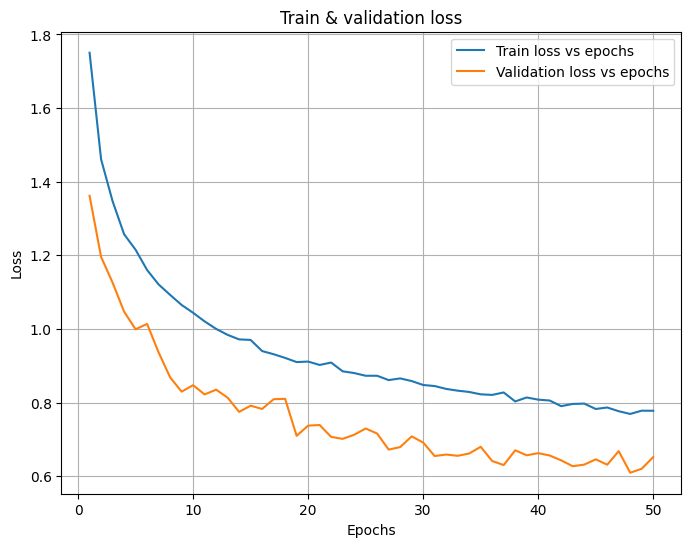

In [31]:
fig,ax=plt.subplots(figsize=(8,6))

base_resnet50_loss_values = history_resnet50_model_loaded['loss']
base_resnet50_val_loss_values = history_resnet50_model_loaded['val_loss']


epochs = range(1,len(base_resnet50_loss_values)+1)

ax.plot(epochs,base_resnet50_loss_values,label='Train loss vs epochs')
ax.plot(epochs,base_resnet50_val_loss_values,label='Validation loss vs epochs')

ax.set_title('Train & validation loss')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Loss');

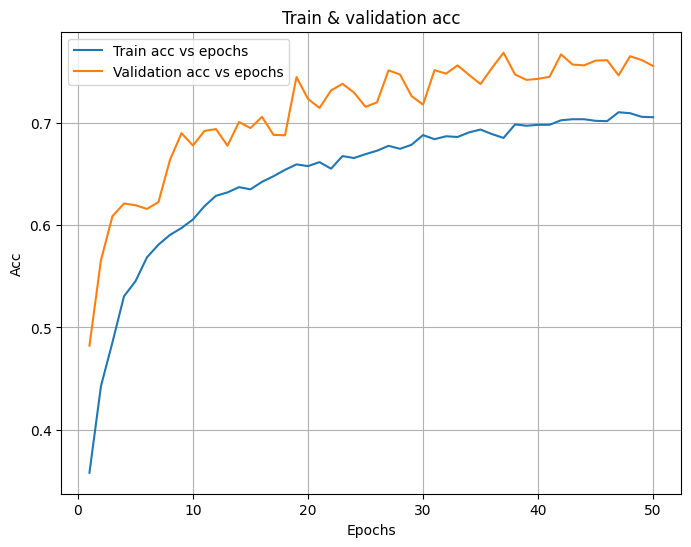

In [15]:
fig,ax=plt.subplots(figsize=(8,6))

base_mobilenet50_acc_values = history_resnet50_model_loaded['accuracy']
base_mobilenet50_val_acc_values = history_resnet50_model_loaded['val_accuracy']


epochs = range(1,len(base_mobilenet50_acc_values)+1)

ax.plot(epochs,base_mobilenet50_acc_values,label='Train acc vs epochs')
ax.plot(epochs,base_mobilenet50_val_acc_values,label='Validation acc vs epochs')

ax.set_title('Train & validation acc')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Acc');

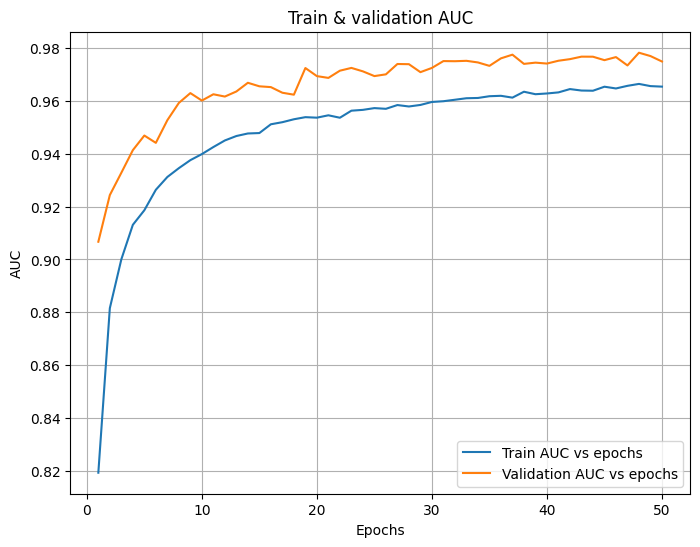

In [32]:
fig,ax=plt.subplots(figsize=(8,6))

base_resnet50_AUC_values = history_resnet50_model_loaded['auc']
base_resnet50_val_AUC_values = history_resnet50_model_loaded['val_auc']


epochs = range(1,len(base_resnet50_AUC_values)+1)

ax.plot(epochs,base_resnet50_AUC_values,label='Train AUC vs epochs')
ax.plot(epochs,base_resnet50_val_AUC_values,label='Validation AUC vs epochs')

ax.set_title('Train & validation AUC')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('AUC');

In [36]:
resnet50_test_class_pred = resnet50_model_loaded.predict(test_generator_resnet50,steps=len(test_generator_resnet50))

77/77 [==============================] - 226s 3s/step


In [37]:
resnet50_predicted_classes = np.argmax(resnet50_test_class_pred, axis=-1)
resnet50_predicted_classes

array([3, 0, 0, ..., 9, 6, 9])

In [42]:
test_true_classes = test_generator_resnet50.classes
test_true_classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [43]:
test_class_labels = list(test_generator_resnet50.class_indices.keys()) 
test_class_labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [44]:
test_class_labels_mapping = {0: 'Tshirts', 1: 'Shirts', 2: 'casual_shoes',3: 'watches' , 4: 'sports_shoes', 5: 'kurtas',6:'handbags',7:'heels',8:'sunglasses',9:'wallets'}
test_class_labels_words = list(test_class_labels_mapping.values())
test_class_labels_words 

['Tshirts',
 'Shirts',
 'casual_shoes',
 'watches',
 'sports_shoes',
 'kurtas',
 'handbags',
 'heels',
 'sunglasses',
 'wallets']

In [49]:
resnet50_cm_digits = confusion_matrix(test_true_classes, resnet50_predicted_classes)
resnet50_cm_digits

array([[1017,  182,    0,  130,    1,   75,    3,    4,    1,    1],
       [  73,  510,    0,   24,    1,   28,    2,    2,    2,    1],
       [   0,    0,  330,    9,  188,    1,    0,   36,    5,    0],
       [   4,    1,    0,  497,    0,    0,    2,    3,    1,    0],
       [   1,    0,   70,    7,  312,    0,    0,   15,    0,    2],
       [  31,   39,    0,    1,    0,  296,    2,    0,    0,    0],
       [  15,    1,    4,   84,    9,    0,  218,    8,    6,    7],
       [   0,    0,   27,   13,   44,    0,    1,  169,   10,    0],
       [   0,    0,    0,    1,    0,    0,    0,   10,  202,    0],
       [   4,    0,    1,    8,    0,    0,    3,    6,    1,  164]])

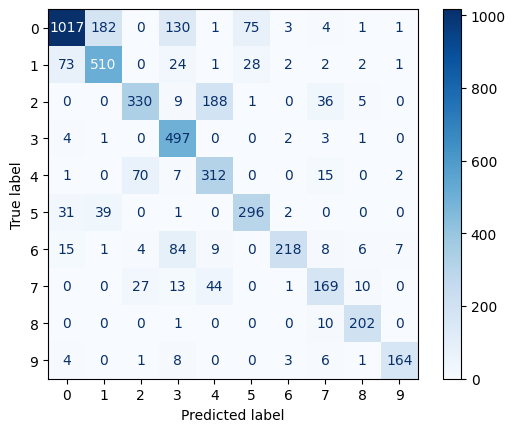

In [50]:
resnet50_disp = ConfusionMatrixDisplay(
    confusion_matrix=resnet50_cm_digits)

resnet50_disp.plot(cmap=plt.cm.Blues)
plt.show()

In [51]:
resnet50_report = classification_report(test_true_classes, resnet50_predicted_classes, target_names=test_class_labels_words,)
print(resnet50_report)

              precision    recall  f1-score   support

     Tshirts       0.89      0.72      0.79      1414
      Shirts       0.70      0.79      0.74       643
casual_shoes       0.76      0.58      0.66       569
     watches       0.64      0.98      0.78       508
sports_shoes       0.56      0.77      0.65       407
      kurtas       0.74      0.80      0.77       369
    handbags       0.94      0.62      0.75       352
       heels       0.67      0.64      0.65       264
  sunglasses       0.89      0.95      0.92       213
     wallets       0.94      0.88      0.91       187

    accuracy                           0.75      4926
   macro avg       0.77      0.77      0.76      4926
weighted avg       0.78      0.75      0.75      4926



In [52]:
resnet50_report_output = classification_report(test_true_classes, resnet50_predicted_classes, target_names=test_class_labels_words,output_dict=True)
print(resnet50_report_output)

{'Tshirts': {'precision': 0.8882096069868995, 'recall': 0.7192362093352193, 'f1-score': 0.794841735052755, 'support': 1414}, 'Shirts': {'precision': 0.6957708049113234, 'recall': 0.7931570762052877, 'f1-score': 0.741279069767442, 'support': 643}, 'casual_shoes': {'precision': 0.7638888888888888, 'recall': 0.5799648506151143, 'f1-score': 0.6593406593406593, 'support': 569}, 'watches': {'precision': 0.6421188630490956, 'recall': 0.9783464566929134, 'f1-score': 0.7753510140405616, 'support': 508}, 'sports_shoes': {'precision': 0.5621621621621622, 'recall': 0.7665847665847666, 'f1-score': 0.6486486486486487, 'support': 407}, 'kurtas': {'precision': 0.74, 'recall': 0.8021680216802168, 'f1-score': 0.7698309492847855, 'support': 369}, 'handbags': {'precision': 0.9437229437229437, 'recall': 0.6193181818181818, 'f1-score': 0.7478559176672384, 'support': 352}, 'heels': {'precision': 0.6679841897233202, 'recall': 0.6401515151515151, 'f1-score': 0.6537717601547388, 'support': 264}, 'sunglasses': {

In [53]:
resnet_f1_scores = {class_name: resnet50_report_output[class_name]['f1-score'] for class_name in test_class_labels_words}
resnet_f1_scores_rounded = {class_name: round(score, 2) for class_name, score in resnet_f1_scores.items()}
resnet_f1_scores_rounded

{'Tshirts': 0.79,
 'Shirts': 0.74,
 'casual_shoes': 0.66,
 'watches': 0.78,
 'sports_shoes': 0.65,
 'kurtas': 0.77,
 'handbags': 0.75,
 'heels': 0.65,
 'sunglasses': 0.92,
 'wallets': 0.91}

In [54]:
resnet50_model_precision = resnet50_report_output['weighted avg']['precision']
resnet50_model_precision 

0.7792352243043265

In [55]:
resnet50_model_recall = resnet50_report_output['weighted avg']['recall']
resnet50_model_recall 

0.7541615915550142

In [56]:
resnet50_model_f1score = resnet50_report_output['weighted avg']['f1-score']
resnet50_model_f1score 

0.7547840376161966

In [63]:
resnet50_model_accuracy = accuracy_score(test_true_classes, resnet50_predicted_classes)
resnet50_model_accuracy

0.7541615915550142

In [61]:
test_true_classes_onehot = tf.keras.utils.to_categorical(test_true_classes, num_classes=num_classes)

resnet50_model_mean_auc = roc_auc_score(test_true_classes_onehot, resnet50_test_class_pred, multi_class='ovr', average='macro')
resnet50_model_mean_auc

0.9775222205378385

In [62]:
#Create a summary table
table_columns = ['Model Name','Accuracy_All','AUC_All','Precision_All','Recall_All','F1_score_All'] + list(resnet_f1_scores_rounded.keys())
sumary_table = pd.DataFrame(columns=table_columns)
sumary_table

,Model Name,Accuracy_All,AUC_All,Precision_All,Recall_All,F1_score_All,Tshirts,Shirts,casual_shoes,watches,sports_shoes,kurtas,handbags,heels,sunglasses,wallets


In [64]:
sumary_table.loc[0] = ['resnet50_baseline_model',round(resnet50_model_accuracy,3),round(resnet50_model_mean_auc,3),round(resnet50_model_precision,3),round(resnet50_model_recall,3) ,round(resnet50_model_f1score,3)] + list(resnet_f1_scores_rounded.values())
sumary_table

,Model Name,Accuracy_All,AUC_All,Precision_All,Recall_All,F1_score_All,Tshirts,Shirts,casual_shoes,watches,sports_shoes,kurtas,handbags,heels,sunglasses,wallets
0,resnet50_baseline_model,0.754,0.978,0.779,0.754,0.755,0.79,0.74,0.66,0.78,0.65,0.77,0.75,0.65,0.92,0.91


After observing the performance of this model, it achieved a test accuracy of 75%, surpassing the train accuracy of 69%. This suggests that the model might be generalizing well on unseen data, even better than on the data it was specifically trained on. Such a phenomenon, where test accuracy exceeds train accuracy, can be attributed to several factors:

One contributing factor may be the presence of data augmentation during the training process. Data augmentation increases the diversity of the training data by applying various transformations such as rotations, shifts, and more. This exposure to a broader range of examples helps the model improve its generalization capability.

Another factor that could contribute to the higher test accuracy is the specific distribution of data in the training and test sets. The test set might unintentionally contain examples that are easier for the model to classify correctly due to certain patterns or characteristics that are not as prevalent in the training set. This imbalance in data distributions could lead to better performance on the test set.


Additionally, when considering the f1-scores of the test set, the product types 'sports shoes' and 'heels' have the loweest f1-scores, both at 65%, followed by 'casual shoes' at 66%. One the other hand, the other product types demonstrate much better performance, with f1-score ranging from 75% to 92%.

### ResNet50 + Tuning

In my second ResNet50 model, I will unfreeze the last layers and add 2 convolutional layers along with 2 MaxPooling layers.

In [65]:
resnet50_model_tune1 = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                            weights = 'imagenet')
for layers in resnet50_model_tune1.layers[-1:]:
  layers.trainable = True

In [66]:
resnet50_model_tune1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, None, None, 64)       16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, None, None, 64)       256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, None, None, 64)       0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, None, None, 512)      66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, None, None, 512)      2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, None, None, 512)      0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, None, None, 256)      590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, None, None, 1024)     525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, None, None, 1024)     0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, None, None, 256)      262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, None, None, 1024)     4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, None, None, 1024)     0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, None, None, 1024)     0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, None, None, 512)      2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, None, None, 512)      2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [67]:
def custom_classifier(base_model, num_classes):
    x = base_model.output
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

In [69]:
resnet50_model_tune1 = custom_classifier(resnet50_model_tune1, num_classes)

In [70]:
resnet50_model_tune1.compile(loss='categorical_crossentropy',
                             optimizer='Adam',
                             metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [32]:
history_resnet50_model_tune1 = resnet50_model_tune1.fit(train_generator_resnet50,
                                                  steps_per_epoch=len(train_generator_resnet50),
                                                  epochs=50,
                                                  validation_data=val_generator_resnet50,
                                                  validation_steps=len(val_generator_resnet50))

Epoch 1/50
231/231 [==============================] - 1839s 8s/step - loss: 0.5923 - accuracy: 0.7966 - auc: 0.9784 - precision: 0.8500 - recall: 0.7496 - val_loss: 2.7617 - val_accuracy: 0.1248 - val_auc: 0.5546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
231/231 [==============================] - 1818s 8s/step - loss: 0.2820 - accuracy: 0.9034 - auc: 0.9936 - precision: 0.9161 - recall: 0.8914 - val_loss: 1.8331 - val_accuracy: 0.3771 - val_auc: 0.8093 - val_precision: 0.5564 - val_recall: 0.0569
Epoch 3/50
231/231 [==============================] - 1791s 8s/step - loss: 0.2199 - accuracy: 0.9233 - auc: 0.9957 - precision: 0.9320 - recall: 0.9158 - val_loss: 0.9590 - val_accuracy: 0.6419 - val_auc: 0.9481 - val_precision: 0.7486 - val_recall: 0.5425
Epoch 4/50
231/231 [==============================] - 1797s 8s/step - loss: 0.2032 - accuracy: 0.9280 - auc: 0.9961 - precision: 0.9362 - recall: 0.9216 - val_loss: 0.3262 - val_accuracy: 0.8883 - val_auc: 0.9926 - val

#### Save the model

In [33]:
# resnet50_model.save('resnet50_model_tune1_50epoch.h5')

In [35]:
# hdf5storage.savemat("history_resnet50_model_tune1_50epoch.h5", history_resnet50_model_tune1.history)

#### Evaluate the model

In [71]:
resnet50_model_tune1_loaded = load_model('resnet50_model_tune1_50epoch.h5')

In [23]:
resnet50_model_tune1_loaded.evaluate(train_generator_resnet50)

231/231 [==============================] - 402s 2s/step - loss: 0.8137 - accuracy: 0.6877 - auc: 0.9623 - precision: 0.7757 - recall: 0.5930


[0.8137473464012146,
 0.6877283453941345,
 0.9623228907585144,
 0.7756637334823608,
 0.5929508805274963]

In [24]:
resnet50_model_tune1_loaded.evaluate(test_generator_resnet50)

77/77 [==============================] - 129s 2s/step - loss: 0.6349 - accuracy: 0.7542 - auc: 0.9762 - precision: 0.7986 - recall: 0.6941


[0.6349151134490967,
 0.7541615962982178,
 0.9761607050895691,
 0.7986451983451843,
 0.6940722465515137]

In [72]:
history_resnet50_model_tune1_loaded = hdf5storage.loadmat("history_resnet50_model_tune1_50epoch.h5")

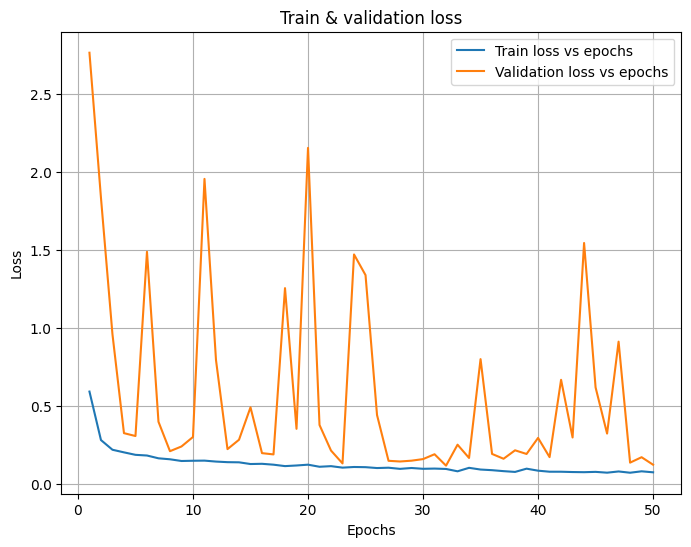

In [26]:
fig,ax=plt.subplots(figsize=(8,6))

resnet50_tune1_loss_values = history_resnet50_model_tune1_loaded['loss']
resnet50_tune1_val_loss_values = history_resnet50_model_tune1_loaded['val_loss']


epochs = range(1,len(resnet50_tune1_loss_values)+1)

ax.plot(epochs,resnet50_tune1_loss_values,label='Train loss vs epochs')
ax.plot(epochs,resnet50_tune1_val_loss_values,label='Validation loss vs epochs')

ax.set_title('Train & validation loss')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Loss');

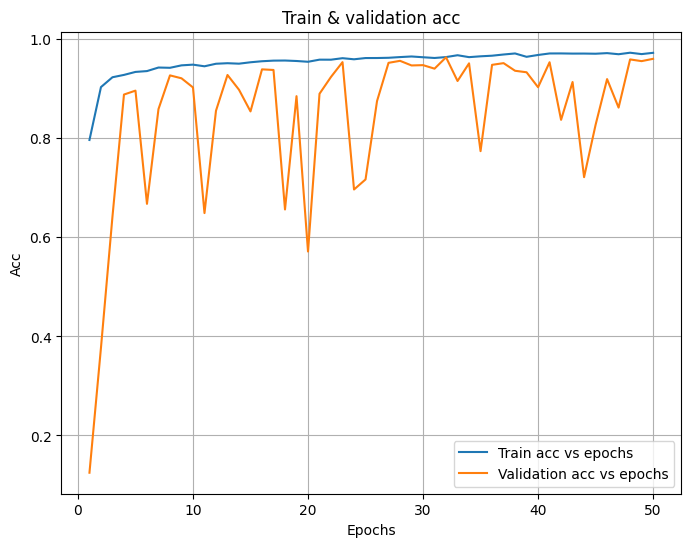

In [27]:
fig,ax=plt.subplots(figsize=(8,6))

resnet50_tune1_acc_values = history_resnet50_model_tune1_loaded['accuracy']
resnet50_tune1_val_acc_values = history_resnet50_model_tune1_loaded['val_accuracy']


epochs = range(1,len(resnet50_tune1_acc_values)+1)

ax.plot(epochs,resnet50_tune1_acc_values,label='Train acc vs epochs')
ax.plot(epochs,resnet50_tune1_val_acc_values,label='Validation acc vs epochs')

ax.set_title('Train & validation acc')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Acc');

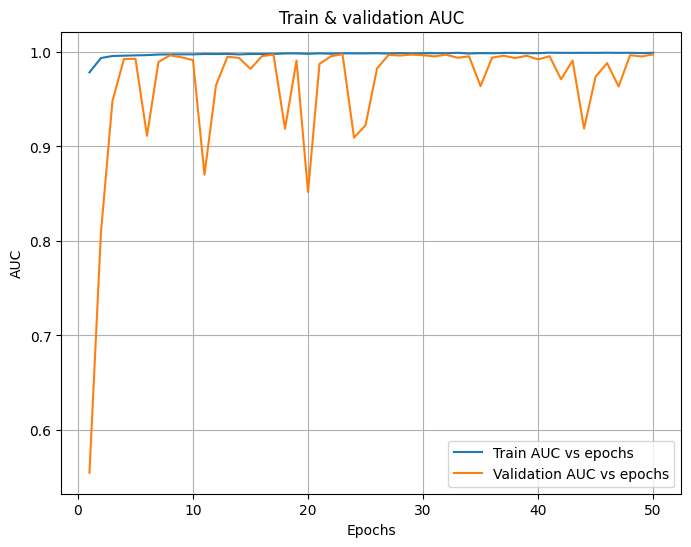

In [28]:
fig,ax=plt.subplots(figsize=(8,6))

resnet50_tune1_AUC_values = history_resnet50_model_tune1_loaded['auc']
resnet50_tune1_val_AUC_values = history_resnet50_model_tune1_loaded['val_auc']


epochs = range(1,len(resnet50_tune1_AUC_values)+1)

ax.plot(epochs,resnet50_tune1_AUC_values,label='Train AUC vs epochs')
ax.plot(epochs,resnet50_tune1_val_AUC_values,label='Validation AUC vs epochs')

ax.set_title('Train & validation AUC')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('AUC');

In [73]:
resnet50_tune1_test_class_pred = resnet50_model_tune1_loaded.predict(test_generator_resnet50,steps=len(test_generator_resnet50))

77/77 [==============================] - 214s 3s/step


For this tuning model, the performance seems to improve during the early epochs but becomes less stable as training progressed. Also, train accuracy and test accuracy are quite the same with the baseline model above, which are 69% and 75%. There is one reason that might the reason to explain the lack of stable validation accuracy as below:
- Model complexity: the addition of extra layers or neurons might lead to increased model complexity, making it harder for the model to generalize well to unseen data. The model is likely to memorize the training data rather than learning general patterns. 

### Conclusion

Comparing the 2 models above, in this modeling section, the ResNet50 baseline stands out as the superior choice. Despite not achieving the same high accuracy as the baseline (93% accuracy), the ResNet50 baseline model demonstrates greater stability in its performance.

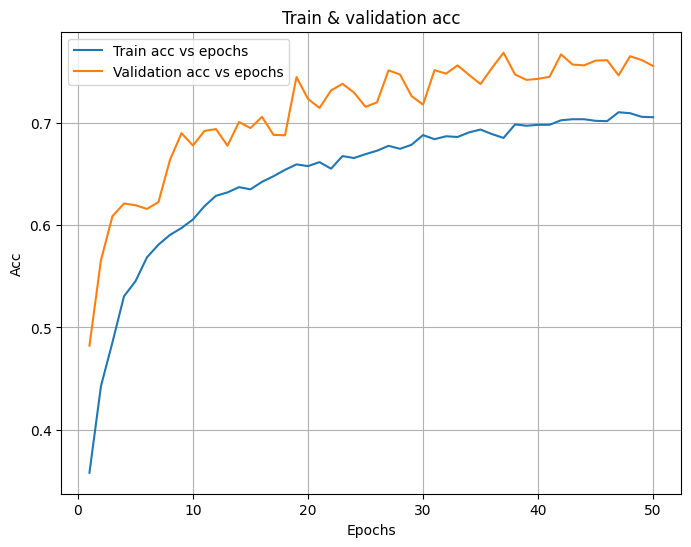

In [76]:
fig,ax=plt.subplots(figsize=(8,6))

base_mobilenet50_acc_values = history_resnet50_model_loaded['accuracy']
base_mobilenet50_val_acc_values = history_resnet50_model_loaded['val_accuracy']


epochs = range(1,len(base_mobilenet50_acc_values)+1)

ax.plot(epochs,base_mobilenet50_acc_values,label='Train acc vs epochs')
ax.plot(epochs,base_mobilenet50_val_acc_values,label='Validation acc vs epochs')

ax.set_title('Train & validation acc')
ax.legend()
ax.set_xlabel('Epochs')
plt.grid()
ax.set_ylabel('Acc');

In [74]:
best_resnet50_f1score_table = sumary_table

In [75]:
best_resnet50_f1score_table.to_csv('best_resnet50_f1score_table.csv')